In [2]:
!pip install Generator

ERROR: Could not find a version that satisfies the requirement Generator (from versions: 0.1-alpha.linux-x86_64)
ERROR: No matching distribution found for Generator

[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: pip install --upgrade pip


In [5]:
import os
import sys

import numpy as np
from generator import generate_samples
from utils import split_and_preprocess
from adjustment_methods import (
    get_ate_ols,
    get_ate_cuped,
    get_ate_cupac,
    get_ate_doubly_robust,
)

import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
data = generate_samples(
    mu_metric=5,
    sigma_metric=1,
    epsilon=2,
    treatment_effect=2,
    size=10_000,
    cov_mu_eps=[(-1,1),(-2,1),(5,2)],
    non_linear=[False, False, True],
    p_binomial=0.5,
    seed=0,
)
data

,Y,T,Y_before,X_1,X_2,X_3,R_1
0,7.483736,1,4.691269,-3.824953,-4.200046,2.980925,0.568277
1,32.065533,0,5.654847,0.688916,-2.150331,5.230241,2.208183
2,26.486386,0,4.991776,-0.221092,-3.104908,4.845359,-2.859181
3,11.467012,1,4.496290,-1.436486,-2.574739,2.640222,-2.315117
4,30.515303,1,4.380978,-0.006295,-1.499460,5.171233,0.551274
...,...,...,...,...,...,...,...
9995,34.964476,1,4.340916,-2.036755,-2.240288,5.536198,-0.736980
9996,10.192216,1,4.611478,-0.730695,-1.020920,0.811343,1.084532
9997,12.366854,0,5.718639,-0.962909,-0.147672,2.959189,-0.547833
9998,55.847281,1,5.632563,-2.793525,-0.481343,7.302269,-0.845858


In [25]:
ate = []
ate_cuped = []
ate_ols_cov = []
ate_cupac = []
ate_doubly_robust = []

N_SAMPLES = 100000
N_SIMULATIONS = 10
REAL_ATE = 0.1

for i in range(N_SIMULATIONS):
    data = generate_samples(
        mu_metric=20,
        sigma_metric=10,
        epsilon=2,
        treatment_effect=REAL_ATE,
        size=N_SAMPLES,
        cov_mu_eps=[(-1,1),(-2,1),(5,5)],
    )

    pre_analysis_data, analysis_data = split_and_preprocess(data, REAL_ATE)
    ate_cupac.append(get_ate_cupac(analysis_data, pre_analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate.append(analysis_data.loc[analysis_data['T']==1, 'Y'].mean() - analysis_data.loc[analysis_data['T']==0, 'Y'].mean())
    ate_ols_cov.append(get_ate_ols(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate_cuped.append(get_ate_cuped(analysis_data))
    ate_doubly_robust.append(get_ate_doubly_robust(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))

results = pd.DataFrame({
    'Mean Diff': ate,
    'Multivariate Regression': ate_ols_cov,
    'CUPED': ate_cuped,
    'CUPAC': ate_cupac,
    'Doubly Robust': ate_doubly_robust,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)
errors = pd.DataFrame({
    'Mean Diff': (np.array(ate) - REAL_ATE)**2,
    'Multivariate Regression': (np.array(ate_ols_cov) - REAL_ATE)**2,
    'CUPED': (np.array(ate_cuped) - REAL_ATE)**2,
    'CUPAC': (np.array(ate_cupac) - REAL_ATE)**2,
    'Doubly Robust': (np.array(ate_doubly_robust) - REAL_ATE)**2,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)

errors.groupby('method').agg(mse=('ATE', 'mean')).reset_index()


,method,mse
0,CUPAC,0.000320
1,CUPED,0.001614
2,Doubly Robust,0.000389
3,Mean Diff,0.010847
4,Multivariate Regression,0.000337


In [26]:
results.groupby('method').agg(mse=('ATE', 'mean')).reset_index()

,method,mse
0,CUPAC,0.100954
1,CUPED,0.107100
2,Doubly Robust,0.103151
3,Mean Diff,0.110379
4,Multivariate Regression,0.100044


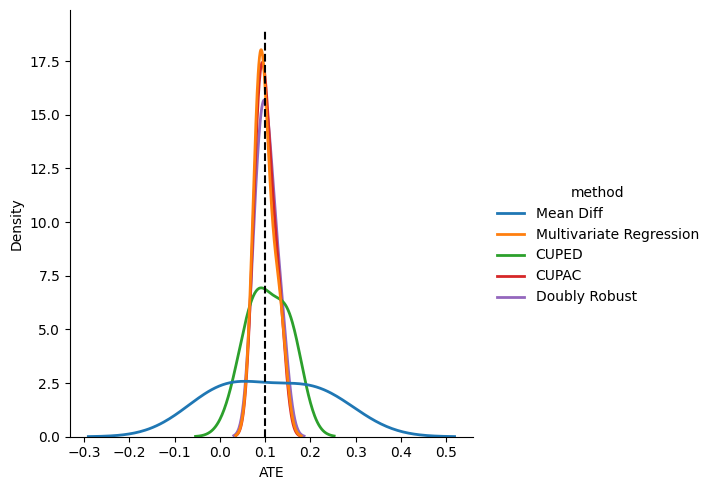

In [27]:
sns.displot(x='ATE',data=results, fill=False, kind='kde', hue='method', common_norm=False, linewidth=2, bw_adjust=1.2);
plt.vlines(REAL_ATE, plt.ylim()[0], plt.ylim()[1], linestyles="dashed", label='ATE',colors='k');
plt.show()

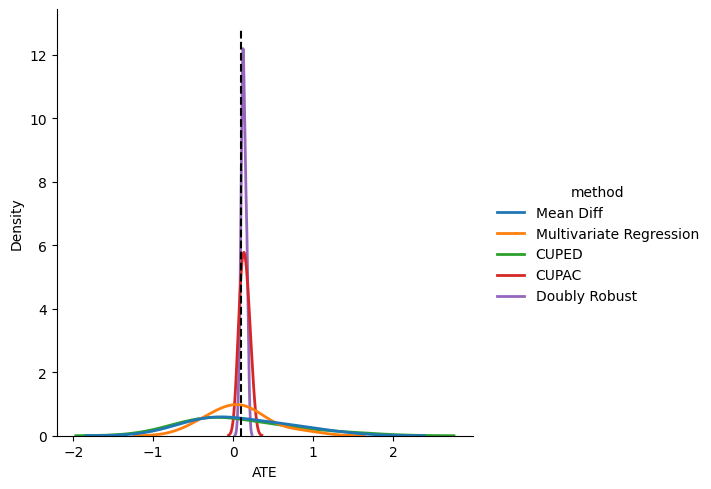

,method,mse
0,CUPAC,0.004397
1,CUPED,0.334792
2,Doubly Robust,0.001734
3,Mean Diff,0.271248
4,Multivariate Regression,0.115252


In [28]:
ate = []
ate_cuped = []
ate_ols_cov = []
ate_cupac = []
ate_doubly_robust = []

N_SAMPLES = 100000
N_SIMULATIONS = 10
REAL_ATE = 0.1

for i in range(N_SIMULATIONS):
    data = generate_samples(
        mu_metric=20,
        sigma_metric=10,
        epsilon=2,
        treatment_effect=REAL_ATE,
        size=N_SAMPLES,
        cov_mu_eps=[(-1,1),(-2,1),(5,5)],
        non_linear=[False, False, True]
    )

    pre_analysis_data, analysis_data = split_and_preprocess(data, REAL_ATE)
    ate_cupac.append(get_ate_cupac(analysis_data, pre_analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate.append(analysis_data.loc[analysis_data['T']==1, 'Y'].mean() - analysis_data.loc[analysis_data['T']==0, 'Y'].mean())
    ate_ols_cov.append(get_ate_ols(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))
    ate_cuped.append(get_ate_cuped(analysis_data))
    ate_doubly_robust.append(get_ate_doubly_robust(analysis_data, covariates=['Y_before', 'X_1', 'X_2', 'X_3']))

results = pd.DataFrame({
    'Mean Diff': ate,
    'Multivariate Regression': ate_ols_cov,
    'CUPED': ate_cuped,
    'CUPAC': ate_cupac,
    'Doubly Robust': ate_doubly_robust,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)
errors = pd.DataFrame({
    'Mean Diff': (np.array(ate) - REAL_ATE)**2,
    'Multivariate Regression': (np.array(ate_ols_cov) - REAL_ATE)**2,
    'CUPED': (np.array(ate_cuped) - REAL_ATE)**2,
    'CUPAC': (np.array(ate_cupac) - REAL_ATE)**2,
    'Doubly Robust': (np.array(ate_doubly_robust) - REAL_ATE)**2,
}).stack(level=0).reset_index(level=1, name='ATE').rename({'level_1': 'method'}, axis=1).reset_index(drop=True)


sns.displot(x='ATE',data=results, fill=False, kind='kde', hue='method', common_norm=False, linewidth=2, bw_adjust=1.2);
plt.vlines(REAL_ATE, plt.ylim()[0], plt.ylim()[1], linestyles="dashed", label='ATE',colors='k');
plt.show()
errors.groupby('method').agg(mse=('ATE', 'mean')).reset_index()